# KNN - K Nearest Neighbours

Importing libraries

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from ipynb.fs.defs.additional_metrics import *

Defining functions that will perform .fit() and .predict() while calculating execution time 

In [2]:
def knn_fit_with_time(knn, X_trainCV, y_trainCV, time_fit_tmp):
    start = time.time()     
    knn.fit(X_trainCV, y_trainCV)
    time_fit_tmp.append(time.time()-start)

In [3]:
def knn_predict_with_time(knn, X_testCV, time_pred_tmp):
    start = time.time()
    y_pred = knn.predict(X_testCV)
    time_pred_tmp.append(time.time()-start)
    return y_pred

## Trained on 30% samples of the original training dataset

In [4]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [5]:
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_train_std, y_train, test_size=0.7, stratify=y_train, random_state=42)

In [6]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
acc = []
i, p_val, best_acc, best_k = 0, 0, 0, 0
best_m, best_w = '', ''

for k in range(1,11):
    for m in ['euclidean','manhattan','chebyshev','minkowski']:   
        for w in ['uniform','distance']:

            acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []
            
            p_val = 3 if m == 'minkowski' else 2

            indexes = kf.split(X_train_30, y_train_30)
            
            for train_index, test_index in indexes:

                X_trainCV1 = X_train_30.iloc[train_index,:]
                y_trainCV1 = y_train_30.iloc[train_index]
                X_testCV1 = X_train_30.iloc[test_index,:]
                y_testCV1 = y_train_30.iloc[test_index]
        
                knn1 = KNeighborsClassifier(n_neighbors = k, metric = m, p = p_val, weights = w, n_jobs = 20)
                
                knn_fit_with_time(knn1, X_trainCV1, y_trainCV1, time_fit_tmp)
                y_pred1 = knn_predict_with_time(knn1, X_testCV1, time_pred_tmp)

                c1 = confusion_matrix(y_testCV1, y_pred1)   
                acc_tmp.append(np.trace(c1)/sum(sum(c1)))
                                
            print(f"{i+1}. K = {k}, m = {m}, w = {w}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
            acc.append(np.mean(acc_tmp))
            i += 1
            
            if np.mean(acc_tmp) > best_acc:
                best_acc = np.mean(acc_tmp)
                best_k, best_m, best_w = k, m, w
            
    print('')
      
print('-------------------')
print('Best accuracy is in iteration number:', np.argmax(acc) + 1, ' | for k =', best_k, ', m =', best_m, ', w =', best_w)

1. K = 1, m = euclidean, w = uniform, Average accuracy: 0.818611 | Average fit time: 0.024822s | Average predict time: 1.259545s
2. K = 1, m = euclidean, w = distance, Average accuracy: 0.818611 | Average fit time: 0.027425s | Average predict time: 1.234321s
3. K = 1, m = manhattan, w = uniform, Average accuracy: 0.829167 | Average fit time: 0.027025s | Average predict time: 21.423069s
4. K = 1, m = manhattan, w = distance, Average accuracy: 0.829167 | Average fit time: 0.021219s | Average predict time: 20.260412s
5. K = 1, m = chebyshev, w = uniform, Average accuracy: 0.646278 | Average fit time: 0.019217s | Average predict time: 17.206237s
6. K = 1, m = chebyshev, w = distance, Average accuracy: 0.646278 | Average fit time: 0.020419s | Average predict time: 17.176409s
7. K = 1, m = minkowski, w = uniform, Average accuracy: 0.799000 | Average fit time: 0.019818s | Average predict time: 86.559463s
8. K = 1, m = minkowski, w = distance, Average accuracy: 0.799000 | Average fit time: 0.0

#### Checking if different algorithms speed up the process

In [7]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

best_time_fit = 99999
best_a = ''

for a in ['ball_tree', 'kd_tree']:
    
    acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []

    indexes = kf.split(X_train_30, y_train_30)

    for train_index, test_index in indexes:

        X_trainCV1 = X_train_30.iloc[train_index,:]
        y_trainCV1 = y_train_30.iloc[train_index]
        X_testCV1 = X_train_30.iloc[test_index,:]
        y_testCV1 = y_train_30.iloc[test_index]

        knn1 = KNeighborsClassifier(n_neighbors = best_k, algorithm = a, metric = best_m, weights = best_w, n_jobs = 20)

        knn_fit_with_time(knn1, X_trainCV1, y_trainCV1, time_fit_tmp)
        y_pred1 = knn_predict_with_time(knn1, X_testCV1, time_pred_tmp)

        c1 = confusion_matrix(y_testCV1, y_pred1)
        acc_tmp.append(np.trace(c1)/sum(sum(c1)))

    print(f"a = {a}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")

    if np.mean(time_fit_tmp) < best_time_fit:
        best_time_fit = np.mean(time_fit_tmp)
        best_a = a

print('')    
print('-------------------')
print('Best accuracy is for a =', best_a)

a = ball_tree, Average accuracy: 0.840167 | Average fit time: 1.098598s | Average predict time: 8.016491s
a = kd_tree, Average accuracy: 0.840167 | Average fit time: 2.094103s | Average predict time: 8.988890s

-------------------
Best accuracy is for a = ball_tree


#### Training on 30% training samples, test on test dataset

In [8]:
knn1 = KNeighborsClassifier(n_neighbors = best_k, algorithm = best_a, metric = best_m, weights = best_w, n_jobs = 20)

start1 = time.time()
knn1.fit(X_train_30, y_train_30)
fit_time = time.time() - start1

start2 = time.time()
y_pred2 = knn1.predict(X_test_std)
pred_time = time.time() - start2

c2 = confusion_matrix(y_test, y_pred2, labels=[0,1,2,3,4,5,6,7,8,9])

print(f"Accuracy: {np.trace(c2)/sum(sum(c2)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('KNN parameters: a = ', best_a, ', k = ', best_k, ', m = ', best_m, ', w = ', best_w, sep='')

Accuracy: 0.847500 | Average fit time: 1.509372s | Average predict time: 27.881866s
-------------------
KNN parameters: a = ball_tree, k = 4, m = manhattan, w = distance


.

## Trained on 100% samples of the original training dataset

In [9]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc, acc_tmp, time_fit_tmp, time_pred_tmp = [], [], [], []
     
indexes = kf.split(X_train, y_train)

for train_index, test_index in indexes:
    
    X_trainCV2 = X_train_std.iloc[train_index,:]
    y_trainCV2 = y_train.iloc[train_index]
    X_testCV2 = X_train_std.iloc[test_index,:]
    y_testCV2 = y_train.iloc[test_index]

    knn2 = KNeighborsClassifier(n_neighbors = best_k, algorithm = best_a, metric = best_m, weights = best_w, n_jobs = 20)
    
    knn_fit_with_time(knn2, X_trainCV2, y_trainCV2, time_fit_tmp)
    y_pred3 = knn_predict_with_time(knn2, X_testCV2, time_pred_tmp)
    
    c3 = confusion_matrix(y_testCV2, y_pred3)
    acc_tmp.append(np.trace(c3)/sum(sum(c3)))
    
    print(f"        Accuracy: {np.trace(c3)/sum(sum(c3)):.6f} | Fit time: {time_fit_tmp[-1]:.6f}s | Predict time: {time_pred_tmp[-1]:.6f}s")
    
print("")    
print('-------------------')
print(f"Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")

        Accuracy: 0.864500 | Fit time: 4.581233s | Predict time: 105.538953s
        Accuracy: 0.864333 | Fit time: 4.572157s | Predict time: 110.816752s
        Accuracy: 0.865250 | Fit time: 4.571157s | Predict time: 102.495431s
        Accuracy: 0.866333 | Fit time: 5.544041s | Predict time: 109.344413s
        Accuracy: 0.863000 | Fit time: 4.595178s | Predict time: 109.261338s

-------------------
Average accuracy: 0.864683 | Average fit time: 4.772753s | Average predict time: 107.491377s


##### Training on 100% training samples, test on test dataset

In [11]:
knn2 =  KNeighborsClassifier(n_neighbors = best_k, algorithm = best_a, metric = best_m, weights = best_w, n_jobs = 20)

start1 = time.time()
knn2.fit(X_train_std, y_train)
fit_time = time.time() - start1

start2 = time.time()
y_pred4 = knn2.predict(X_test_std)
pred_time = time.time() - start2

c4 = confusion_matrix(y_test, y_pred4, labels=[0,1,2,3,4,5,6,7,8,9])

print(f"Accuracy: {np.trace(c4)/sum(sum(c4)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('KNN parameters: a = ', best_a, ', k = ', best_k, ', m = ', best_m, ', w = ', best_w, sep='')

Accuracy: 0.870600 | Average fit time: 5.784260s | Average predict time: 113.860519s
-------------------
KNN parameters: a = ball_tree, k = 4, m = manhattan, w = distance


.

## Trained on 100% samples with PCA reduction

In [12]:
train_data = pd.read_csv("../datasets/fashion-mnist_train.csv")
X_train = train_data.iloc[:,1:]
y_train = train_data.iloc[:,0]

test_data = pd.read_csv("../datasets/fashion-mnist_test.csv")
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:,0]

X_train_std = (X_train - X_train.mean()) / X_train.std()
X_test_std = (X_test - X_test.mean()) / X_test.std()

In [13]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = []
i, p_val, best_acc, best_k, best_pca = 0, 0, 0, 0, 0
best_m = ''

for k in range(1,11):
    for m in ['euclidean','manhattan','chebyshev']:   
        for pc in [0.8, 0.85, 0.9, 0.95]:

            acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []
        
            indexes = kf.split(X_train, y_train)

            for train_index, test_index in indexes:

                X_trainCV3 = X_train_std.iloc[train_index,:]
                y_trainCV3 = y_train.iloc[train_index]
                X_testCV3 = X_train_std.iloc[test_index,:]
                y_testCV3 = y_train.iloc[test_index]

                pca = PCA(n_components=pc)
                pca.fit(X_trainCV3)
                X_train_r = pca.transform(X_trainCV3)
                X_test_r = pca.transform(X_testCV3)

                knn3 = KNeighborsClassifier(n_neighbors = k, metric = m, weights = 'distance', n_jobs = 20)
                         
                knn_fit_with_time(knn3, X_train_r, y_trainCV3, time_fit_tmp)
                y_pred5 = knn_predict_with_time(knn3, X_test_r, time_pred_tmp)
                    
                c5 = confusion_matrix(y_testCV3, y_pred5, labels=[0,1,2,3,4,5,6,7,8,9])
                acc_tmp.append(np.trace(c5)/sum(sum(c5)))

            print(f"{i+1}. pca = {pc}, K = {k}, m = {m}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")
            acc.append(np.mean(acc_tmp))
            i += 1

            if np.mean(acc_tmp) > best_acc:
                best_acc = np.mean(acc_tmp)
                best_k, best_m, best_pca = k, m, pc
            
        print('')
            
print('-------------------')
print('Best accuracy is in iteration number:', np.argmax(acc) + 1, ' | for k =', best_k, ', m =', best_m, ', pca =', best_pca, ', w = distance')

1. pca = 0.8, K = 1, m = euclidean, Average accuracy: 0.835733 | Average fit time: 0.006406s | Average predict time: 8.068737s
2. pca = 0.85, K = 1, m = euclidean, Average accuracy: 0.844717 | Average fit time: 0.008408s | Average predict time: 8.169828s
3. pca = 0.9, K = 1, m = euclidean, Average accuracy: 0.849500 | Average fit time: 0.012812s | Average predict time: 8.387025s
4. pca = 0.95, K = 1, m = euclidean, Average accuracy: 0.851033 | Average fit time: 0.019418s | Average predict time: 9.101206s

5. pca = 0.8, K = 1, m = manhattan, Average accuracy: 0.840983 | Average fit time: 0.007007s | Average predict time: 6.723313s
6. pca = 0.85, K = 1, m = manhattan, Average accuracy: 0.848367 | Average fit time: 0.007808s | Average predict time: 7.551867s
7. pca = 0.9, K = 1, m = manhattan, Average accuracy: 0.854983 | Average fit time: 0.012012s | Average predict time: 11.938054s
8. pca = 0.95, K = 1, m = manhattan, Average accuracy: 0.854433 | Average fit time: 0.018617s | Average pr

#### Checking if different algorithms speed up the process

In [14]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

best_time_fit = 99999
best_a = ''

for a in ['ball_tree', 'kd_tree']:

    acc_tmp, time_fit_tmp, time_pred_tmp = [], [], []

    indexes = kf.split(X_train, y_train)

    for train_index, test_index in indexes:

        X_trainCV3 = X_train_std.iloc[train_index,:]
        y_trainCV3 = y_train.iloc[train_index]
        X_testCV3 = X_train_std.iloc[test_index,:]
        y_testCV3 = y_train.iloc[test_index]

        pca = PCA(n_components = best_pca)
        pca.fit(X_trainCV3)
        X_train_r = pca.transform(X_trainCV3)
        X_test_r = pca.transform(X_testCV3)

        knn3 = KNeighborsClassifier(n_neighbors = best_k, algorithm = a, metric = best_m, weights = 'distance', n_jobs = 20)
        
        knn_fit_with_time(knn3, X_train_r, y_trainCV3, time_fit_tmp)
        y_pred5 = knn_predict_with_time(knn3, X_test_r, time_pred_tmp)
        
        c5 = confusion_matrix(y_testCV3, y_pred5, labels=[0,1,2,3,4,5,6,7,8,9])
        acc_tmp.append(np.trace(c5)/sum(sum(c5)))

    print(f"a = {a}, Average accuracy: {np.mean(acc_tmp):.6f} | Average fit time: {np.mean(time_fit_tmp):.6f}s | Average predict time: {np.mean(time_pred_tmp):.6f}s")

    if np.mean(time_fit_tmp) < best_time_fit:
        best_time_fit = np.mean(time_fit_tmp)
        best_a = a

print('')    
print('-------------------')
print('Best accuracy is for a =', best_a)

a = ball_tree, Average accuracy: 0.869100 | Average fit time: 0.821747s | Average predict time: 19.345773s
a = kd_tree, Average accuracy: 0.869100 | Average fit time: 1.443111s | Average predict time: 23.922149s

-------------------
Best accuracy is for a = ball_tree


##### Training on 100% training samples with PCA reduction, test on test dataset

In [16]:
pca = PCA(n_components=best_pca)
pca.fit(X_train_std)
X_train_r = pca.transform(X_train_std)
X_test_r = pca.transform(X_test_std)

knn3 = KNeighborsClassifier(n_neighbors = best_k, algorithm = best_a, metric = best_m, weights = "distance", n_jobs = 20)

start1 = time.time()
knn3.fit(X_train_r, y_train)
fit_time = time.time() - start1

start2 = time.time()
y_pred6 = knn3.predict(X_test_r)
pred_time = time.time() - start2

c6 = confusion_matrix(y_test, y_pred6, labels=[0,1,2,3,4,5,6,7,8,9])

print(f"Accuracy: {np.trace(c6)/sum(sum(c6)):.6f} | Average fit time: {fit_time:.6f}s | Average predict time: {pred_time:.6f}s")
print('-------------------')
print('KNN parameters: a =', best_a, ', k =', best_k, ', m =', best_m, ', pca =', best_pca, ', w = distance')

Accuracy: 0.873200 | Average fit time: 1.075978s | Average predict time: 22.440977s
-------------------
KNN parameters: a = ball_tree , k = 6 , m = manhattan , pca = 0.9 , w = distance


In [17]:
# confusion matrix
print(c6)

[[852   1  13  16   5   0 107   1   4   1]
 [  4 974   0  15   2   0   5   0   0   0]
 [ 16   2 764  13 112   1  91   0   1   0]
 [ 28   5   7 901  35   0  24   0   0   0]
 [  1   0  57  20 834   0  87   0   1   0]
 [  1   0   0   0   0 892   4  61   3  39]
 [164   1  72  24  72   1 658   0   8   0]
 [  0   0   0   0   0  11   0 937   0  52]
 [  4   1   6   1   7   1  13   4 960   3]
 [  0   0   0   0   0   4   1  35   0 960]]


In [18]:
print(accuracy_per_class(c6, y_test.unique()))

For class 0 accuracy is: 0.9634
For class 1 accuracy is: 0.9964
For class 2 accuracy is: 0.9609
For class 3 accuracy is: 0.9812
For class 8 accuracy is: 0.9601
For class 6 accuracy is: 0.9874
For class 5 accuracy is: 0.9326
For class 4 accuracy is: 0.9836
For class 7 accuracy is: 0.9943
For class 9 accuracy is: 0.9865
-------------
0.9746399999999997


In [19]:
print(sensitivity_per_class(c6, y_test.unique()))

For class 0 sensitivity is: 0.852
For class 1 sensitivity is: 0.974
For class 2 sensitivity is: 0.764
For class 3 sensitivity is: 0.901
For class 8 sensitivity is: 0.834
For class 6 sensitivity is: 0.892
For class 5 sensitivity is: 0.658
For class 4 sensitivity is: 0.937
For class 7 sensitivity is: 0.96
For class 9 sensitivity is: 0.96
-------------
0.8732


## Examples of wrong classification

In [20]:
y_pred_np = y_pred6
print(type(y_pred6))

y_test_np = y_test.to_numpy()
print(type(y_test_np))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [21]:
def differences(a,b):
    list = []
    for j in range(len(a)):
        if b[j] != a[j]:
            list = list + [j]        
    arrayIndexes = np.asarray(list)
    return arrayIndexes

In [22]:
diff = differences(y_pred_np, y_test_np)
print(diff[:9])

[ 5  7 19 38 40 41 51 59 73]


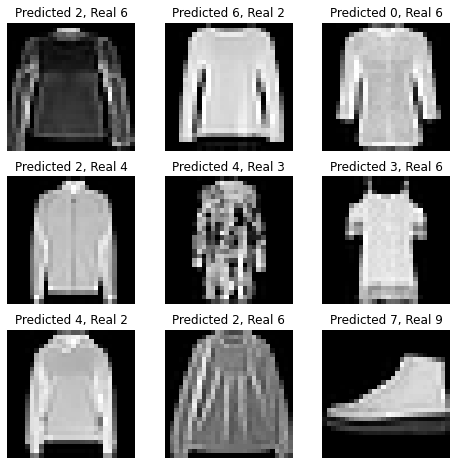

In [23]:
plt.figure(figsize=(8,8))

for j in range(0,9):  
    plt.subplot(3,3,j+1)    
    arr = X_test.iloc[diff[j+100],:].to_numpy()
    
    arr = arr.reshape(28,28)
    arr = arr.astype(np.uint8)
    img = Image.fromarray(arr, "L")
    
    plt.imshow(img, cmap = 'gray')
    plt.title(f"Predicted {y_pred_np[diff[j+100]]}, Real {y_test_np[diff[j+100]]}")
    plt.axis("off")

plt.show()